In [1]:
import numpy as np
from scipy.special import hankel1 as besselh
from scipy.special import iv as besseli
from scipy.special import kv as besselk
import scipy.integrate as integrate
import scipy.linalg as linalg
import matplotlib.pyplot as plt
from math import sqrt, cosh, cos, sinh, sin, pi
from scipy.optimize import newton, minimize_scalar
from constants import *
from coupling import *
from equations import *

In [2]:
N = n
# Boundary 2e - unknowns [C_1n_1(0:N) C_1n_2(0:N) C_2n_2(0:N) B_n(0:N)];
coefs_2E = np.array([[0,R_1n_2(i, a2),R_2n_2(i, a2),-Lambda_k_a2(i)] for i in range(N)]) # for i in range(N) #R_1n_1 =0? add them later when setting up Matrix to invert
rhs_2E =np.array ([-integrate.romberg(phi_p_a2, -h, -d2) * Z_n_i2(i) for i in range(N)]) #at a2 phi_p_i2

# velocity matching boundary 2e--

coefs_velocity_2E = np.array([[0,diff_R_1n_2(i, a2),diff_R_2n_2(i, a2),- diff_Lambda_k_a2(i)] for i in range(N)]) #R_1n_1= 0 for B_n as there is no B_n here
rhs_velocity_2E = np.array([-integrate.romberg(diff_phi_p_i2_a2, -h, -d2) * Z_n_e(i) for i in range(N)])

In [3]:
coefs_12 = np.array([[-R_1n_1(i, a1),R_1n_2(i, a1),R_2n_2(i, a1),0] for i in range(N)]).astype(float) #Lambda_k = 0 for B_n as there is no B_n here
rhs_12 = np.array([-(integrate.romberg(phi_p_i1_i2_a1,-h, -d1)) * Z_n_i1(i) for i in range(N)])
#get a separate function for difference of phi_pi_i1 and phi_pi_i2 as a function of z evaluated at a1
#velocity matching - MISSING DIFF o R_s
coefs_velocity_12 = np.array([[-diff_R_1n_1(i, a1),diff_R_1n_2(i, a1),diff_R_2n_2(i, a1),0] for i in range(N)]) #Lambda_k = 0 for B_n as there is no B_n here
rhs_velocity_12 = np.array([-(integrate.romberg(diff_phi_p_i1_i2_a1, -h, -d1)) * Z_n_i2(i) for i in range(N)])

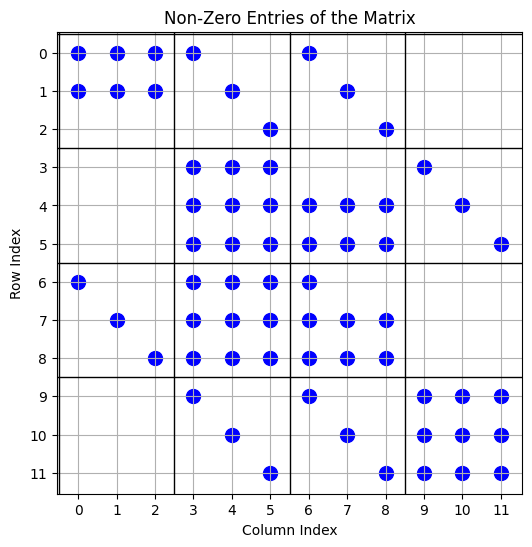

[[ 3.75000000e+00+0.j  2.06731780e-16+0.j -2.06731780e-16+0.j]
 [-1.41541658e-01+0.j  3.60306238e-01+0.j  2.57361599e-01+0.j]
 [ 0.00000000e+00+0.j  0.00000000e+00+0.j  0.00000000e+00+0.j]]


In [26]:
# CREATING THE A MATRIX

N = 3
# Initialize the A matrix with zeros as well as b vector
A = np.zeros((4 * N, 4 * N), dtype=complex)
b = np.zeros(4*N, dtype=complex)

# Init the first row of block matrices (using d1)
# First block (dense)
for j in range(N): 
    for n in range(N):
        A[j][n] = R_1n_1(j, a1) * A_nj2(n, j)
        # A[j][n] = R_1n_1(j, a1) * A_nj2(n, j)

# Second and third blocks (diagonal)
for i in range(N): 
    A[i][N+i] = (h - d1) * R_1n_2(i, a1)
    A[i][2*N+i] = (h - d1) * R_1n_1(i, a1)

# Fourth block (zero)

###########################################################################
# Init the second row of block matrices (using d2)
# First block (zero)
# Second and third block (dense)
for n in range(N): 
    for k in range(N):
        # print(R_2n_2(j, a2) * A_jn(j, n))
        A[N+n][N+k] = R_1n_2(n, a2) * A_nk(n, k)
        A[N+n][2*N+k] = R_2n_2(n, a2) * A_nk(n, k)

# Fourth block  (diagonal)
for i in range(N): 
    A[N+i][3*N+i] = (h - d2) * Lambda_k_a2(i) 

###########################################################################
# Init the third row of block matrices (using d1)
# First block (diagonal)
for i in range(N): 
    A[2*N+i][i] = (h - d1) * R_1n_1(i, d1)

# Second and third block (dense) 
for j in range(N): 
    for n in range(N): 
        A[2*N+j][N+n] = R_1n_2(j, a1) * A_jn(j, n)
        A[2*N+j][2*N+n] = R_2n_2(j, a1) * A_jn(j, n)
# Fourth block (zero)

###########################################################################
# Init the fourth row of block matrices (using d2)
# First block (zero) 

# Second and third block (diagonal)
for i in range(N): 
    A[3*N+i][N+i] = (h - d2) * R_1n_2(i, d2)
    A[3*N+i][2*N+i] = (h - d2) * R_2n_2(i, d2)
    

# Fourth block (dense)
for k in range(N): 
    for n in range(N):
        A[3*N+k][3*N+n] = R_1n_2(n, a2) * A_nk(n, k)
        


A = np.where(np.abs(A) <= 1e-16, 0, A)


rows, cols = np.nonzero(A)
plt.figure(figsize=(6, 6))
plt.scatter(cols, rows, color='blue', marker='o', s=100) 
plt.gca().invert_yaxis() 
plt.xticks(range(A.shape[1]))
plt.yticks(range(A.shape[0]))

for x in range(0, A.shape[1], 3):
    plt.axvline(x-0.5, color='black', linestyle='-', linewidth=1) 

for y in range(0, A.shape[0], 3):
    plt.axhline(y-0.5, color='black', linestyle='-', linewidth=1) 

plt.grid(True)
plt.title('Non-Zero Entries of the Matrix')
plt.xlabel('Column Index')
plt.ylabel('Row Index')
plt.show()
# plt.imshow(np.real(A))
# plt.colorbar()
print(A[:3,:3])

In [20]:

a_nj = []
a_nj2 = []
a_jn = []
a_jn2 = []
for j in range(N): 
    for n in range(N):
        a_nj.append(A_nj(n, j))
        a_nj2.append(A_nj2(n, j))
        a_jn.append(A_jn(j, n))
        a_jn2.append(A_jn2(j, n))

print(a_nj)
print(a_nj2)
print(a_jn)
print(a_jn2)

[5, 2.923863004626286, -1.4619315023131423, 2.756423737004842e-16, 4.961960058796128, 7.088514369708754, -2.756423737004842e-16, -0.7753062591868949, 2.480980029398064]
[7.5, 4.1346356055072625e-16, -4.1346356055072625e-16, -2.2507907903927653, 5.729577951308233, 4.092555679505881, 4.134635605507262e-16, -5.847257748779062e-16, 5.847257748779062e-16]
[5, 2.756423737004842e-16, -2.756423737004842e-16, 2.923863004626286, 3.307973372530752, -0.5168708394579299, -1.4619315023131423, 4.725676246472502, 1.653986686265376]
[7.5, -2.2507907903927653, 4.134635605507262e-16, 4.1346356055072625e-16, 5.729577951308233, -5.847257748779062e-16, -4.1346356055072625e-16, 4.092555679505881, 5.847257748779062e-16]


In [15]:
X = linalg.solve(A,b)

In [29]:
C_1n_1s = X[:,0]

# NOT SURE ABOUT THE VALUES HERE FOR R_1N_1 or whether i should call LAMBDA_K_A2 or LAMBDA_K_A1 at the end

assert len(C_1n_1s) == N
C_1n_2s = X[:,1]
C_2n_2s = X[:,2]
  # C_2n_1s is all zeros
C_2n_1s = np.zeros(N)
B_ks = X[:,3]
Z_n_i1s = np.array([Z_n_i1(i) for i in range(N)])
Z_n_i2s = np.array([Z_n_i2(i) for i in range(N)])
Z_k_es = np.array([Z_n_e(i) for i in range(N)])
R_1n_1s = np.array([R_1n_1(i, a1) for i in range(N)])
R_2n_1s = np.array([R_2n_1(i) for i in range(N)])
R_1n_2s = np.array([R_1n_2(i, a1) for i in range(N)])
R_2n_2s = np.array([R_2n_2(i, a1) for i in range(N)])
Lambda_ks = np.array([Lambda_k_a2(i) for i in range(N)])

In [27]:
# Perform the matrix operations
phi_h_n_i1_solns_all = (C_1n_1s.T * R_1n_1s + C_2n_1s.T * R_2n_1s) * Z_n_i1s
phi_h_n_i2_solns_all = (C_1n_2s.T * R_1n_2s + C_2n_2s.T * R_2n_2s) * Z_n_i2s
phi_e_k = B_ks.T * Lambda_ks * Z_k_es

# Summing all to get the potential
phi_h1 = np.sum(phi_h_n_i1_solns_all)
phi_h2 = np.sum(phi_h_n_i2_solns_all)
phi_e_sym = np.sum(phi_e_k)

phi_1 = phi_h1 + phi_p_a1(d1)
phi_2 = phi_h2 + phi_p_a2(d2)

total_phi = phi_1 + phi_2
total_phi

-331354.4803100199

In [28]:
import matplotlib.pyplot as plt

z_values = np.linspace(0.1, 10, 25)
r_values = np.linspace(0.1, 20, 25)
z_grid, r_grid = np.meshgrid(z_values, r_values)

#  boooleans to create the region where geometry is supposed to be...and block for contour plot later on.
regione = r_grid > a2
region1 = (r_grid < a1) & (z_grid < d1)
region2 = (r_grid > a1) & (r_grid < a2) & (z_grid > d2)

In [46]:
import numpy as np
from scipy.special import iv as besseli
from scipy.special import kv as besselk
from scipy.special import jv, kn
from scipy.special import hankel1 as besselh
from scipy import integrate  #uses gaussian quadrature method
import numpy as np
from scipy.optimize import minimize_scalar
from scipy.optimize import newton

#FIX constants here...mostly some ratio of h
omega = 2
N = 20
h=10
r=10
a2 = 10
a1 = 5
m0 = 1
d1,d2 = 5,2.5
z = 0
def get_phi(z,r):


# Defining m_k function that will be used later on
  def m_k(h_mat):
      m0_vec = np.array([m0])  # Define the m0_vec array
      m_k_mat = np.zeros((len(m0_vec), 1))

      for freq_idx in range(len(m0_vec)):
          m_k_vec = np.zeros(1)
          m0_i = m0_vec[freq_idx]
          m_k_sq_err = (
              lambda m_k: (m_k * np.tan(m_k * h_mat) - m0_i * np.tanh(m0_i * h_mat)) ** 2
          )
          for k_idx in range(len(m0_vec)):
              m_k_lower = (np.pi * (k_idx) + np.pi / 2) / m0_i + np.finfo(float).eps
              m_k_upper = (np.pi * (k_idx) + np.pi) / m0_i - np.finfo(float).eps
              result = minimize_scalar(
                  m_k_sq_err, bounds=(m_k_lower, m_k_upper), method="bounded"
              )
              m_k_vec[k_idx] = result.x

          shouldnt_be_int = np.round(m0_i * m_k_vec / np.pi - 0.5, 4)
          not_repeated = len(np.unique(m_k_vec)) == len(m_k_vec)
          assert np.all(shouldnt_be_int != np.floor(shouldnt_be_int)) and not_repeated

          m_k_mat[freq_idx, :] = m_k_vec
      return m_k_mat[0][0]


  def m_k_newton(h):
      res = newton(lambda k: k * np.tanh(k * h) - m0**2 / 9.8, x0=1.0, tol=10 ** (-10))
      return res


  # Equation 4:
  def lambda_n1(n):
      return n * np.pi / (h - d1)


  def lambda_n2(n):
      return n * np.pi / (h - d2)


  #############################################
  # Equation 5
  def phi_p_a1(z):
      return (1 / (2 * (h - d1))) * ((z + h) ** 2 - (a1**2) / 2)


  def phi_p_a2(z):
      return (1 / (2 * (h - d2))) * ((z + h) ** 2 - (a2**2) / 2)


  def phi_p_i1_i2_a1(z):
      res = ((h + z) ** 2 - a1**2 / 2) / (2 * d1 - 2 * h) - (
          (h + z) ** 2 - a1**2 / 2
      ) / (2 * d2 - 2 * h)
      return res

  def diff_phi_p_i2_a2(h):
    return a2/(2*d2 - 2*h)

  def diff_phi_p_i1_i2_a1(z): #differentiation of difference of particular solution
    return ((h + z)**2 - a1**2/2)/(2*d1 - 2*h) - ((h + z)**2 - a1**2/2)/(2*d2 - 2*h) #flux/velocity at a2


  #############################################
  # Equation 7: (r specifies the raidus, use a1/a2 for the radius of the cylinder you want)
  def R_1n_1(n, r):
      if n == 0:
          return 0.5
      else:
          return besseli(0, lambda_n1(n) * r) / besseli(0, lambda_n1(n) * a2)


  def R_1n_2(n, r):
      if n == 0:
          return 0.5
      else:
          return besseli(0, lambda_n2(n) * r) / besseli(0, lambda_n2(n) * a2)


  # Differentiating equation 7: (Once again look at changing the r's here
  def diff_R_1n_1(n, r):
      if n == 0:
          return 0
      else:
          top = n * np.pi * besseli(1, np.pi * n * r / (d1 - h))
          bottom = (d1 - h) * besseli(0, np.pi * a2 * n / (d1 - h))
          return top / bottom


  def diff_R_1n_2(n, r):
      if n == 0:
          return 0
      else:
          top = n * np.pi * besseli(1, np.pi * n * r / (d2 - h))
          bottom = (d2 - h) * besseli(0, np.pi * a2 * n / (d2 - h))
          return top / bottom


  #############################################
  # Equation 8:
  # This function is always 0 regardless of the output
  def R_2n_1(n):
      return 0.0


  # My original definition
  def R_2n_2(n, r):
      if n == 0:
          return 0.5 * np.log(r / a2)
      else:
          return besselk(0, lambda_n2(n) * r) / besselk(0, lambda_n2(n) * a2)


  # Differentiating equation 8:
  def diff_R_2n_1(n):
      return 0.0


  def diff_R_2n_2(n, r):
      if n == 0:
          return 1 / (2 * r)
      else:
          top = n * np.pi * besselk(1, -(np.pi * n * r) / (d2 - h))
          bottom = (d2 - h) * besselk(0, -(np.pi * n * r) / (d2 - h))
          return top / bottom


  #############################################
  # Equation 9:
  def Z_n_i1(n):
      if n == 0:
          return 1
      else:
          return np.sqrt(2) * np.cos(lambda_n1(n) * (z + h))


  def Z_n_i2(n):
      if n == 0:
          return 1
      else:
          return np.sqrt(2) * np.cos(lambda_n2(n) * (z + h))


  #############################################
  # Equation 13: (m_k is a function)
  def Lambda_k_a2(k):
      if k == 0:
          return besselh(0, m0 * a2) / besselh(0, m0 * a2)
      else:
          return besselk(0, m_k(k) * a2) / besselk(0, m_k(k) * a2)


  def diff_Lambda_k_a2(n):
      if n == 0:
          numerator = -(m0 * besselh(1, m0 * a2))
          denominator = besselh(0, a2 * m0)
      else:
          numerator = -(m_k(n) * besselk(1, a2 * m_k(n)))
          denominator = besselk(0, a2 * m_k(n))
      return numerator / denominator


  #############################################
  # Equation 2.34 in analytical methods book, also eq 16 in Seah and Yeung 2006:
  def N_k(k):
      if k == 0:
          return 1 / 2 * (1 + sinh(2 * m0 * h) / (2 * m0 * h))
      else:
          return 1 / 2 * (1 + sin(2 * m_k(k) * h) / (2 * m_k(k) * h))


  #############################################
  # Equation 14: (m_k is a function)
  def Z_n_e(k):
      if k == 0:
          return 1 / sqrt(N_k(k)) * cosh(m0 * (z + h))
      else:
          return 1 / sqrt(N_k(k)) * cos(m_k(k) * (z + h))


  #############################################
  # Coupling integrals: (m_k is a function)
  def sq(n): 
      return n ** 2

  def A_jn(j, n):
      if j == 0 and n == 0:
          return h - d1
      if j == 0 and 1 <= n:
          return (-sqrt(2) * sin(pi * n) * (d1 - h)) / (n * pi)
      sigma = (pi * j * (d1 - h)) / (d2 - h)
      if 1 <= j and n == 0:
          return (-sqrt(2) * sin(sigma) * (d2 - h)) / (j * pi)
      if 1 <= j and 1 <= n:
          top = -2 * (j * (d1 - h) * (d2 - h) * (d1 * sin(sigma) * cos(pi * n) - h * sin(sigma) * cos(pi * n)) - n * (d1 - h) * (d2 - h) * (d2 * sin(pi * n) * cos(sigma) - h * sin(pi * n) * cos(sigma)))
          bottom = pi * ((sq(d1) * sq(j)) - (2 * d1 * h * sq(j)) - (sq(d2) * sq(n)) + (2 * d2 * h * sq(n)) + (sq(h) * sq(j)) - (sq(h) * sq(n)))
          return top / bottom     
      else:
          raise ValueError("Invalid values for j and n")


  def A_jn2(j, n):
      if j == 0 and n == 0:
          return h - d2
      sigma = (pi * n * (d2 - h)) / (d1 - h)
      if j == 0 and 1 <= n:
          return (-sqrt(2) * sin(sigma) * (d1 - h)) / (n * pi)
      if 1 <= j and n == 0:
          return (-sqrt(2) * sin(pi * j) * (d2 - h)) / (j * pi)
      if 1 <= j and 1 <= n:
          top = -2 * (j * (d1 - h) * (d2 - h) * (d1 * sin(pi * j) * cos(sigma) - h * sin(pi * j) * cos(sigma)) - n * (d1 - h) * (d2 - h) * (d2 * sin(sigma) * cos(pi * j) - h * sin(sigma) * cos(pi * j)))
          bottom = pi * ((sq(d1) * sq(j)) - (2 * d1 * h * sq(j)) - (sq(d2) * sq(n)) + (2 * d2 * h * sq(n)) + (sq(h) * sq(j)) - (sq(h) * sq(n)))
          return top / bottom     
      else:
          raise ValueError("Invalid values for j and n")

  def A_nj(n, j):
      if j == 0 and n == 0:
          return h - d1
      if 1 <= j and n == 0:
          return (-sqrt(2) * sin(pi * j) * (d1 - h)) / (j * pi)
      sigma = (pi * n * (d1 - h)) / (d2 - h)
      if j == 0 and 1 <= n:
          return (-sqrt(2) * sin(sigma) * (d2 - h)) / (n * pi)
      if 1 <= j and 1 <= n:
          top = -2 * (j * (d1 - h) * (d2 - h) * (d2 * sin(pi * j) * cos(sigma) - h * sin(pi * j) * cos(sigma)) - n * (d1 - h) * (d2 - h) * (d2 * sin(sigma) * cos(pi * j) - h * sin(sigma) * cos(pi * j)))
          bottom = pi * ((-sq(d1) * sq(n)) + (2 * d1 * h * sq(n)) + (sq(d2) * sq(j)) - (2 * d2 * h * sq(j)) + (sq(h) * sq(j)) - (sq(h) * sq(n)))
          return top / bottom     
      else:
          raise ValueError("Invalid values for n and j")

  def A_nj2(n, j):
      if j == 0 and n == 0:
          return h - d2
      sigma = (pi * j * (d2 - h)) / (d1 - h)
      if 1 <= j and n == 0:
          return (-sqrt(2) * sin(sigma) * (d1 - h)) / (j * pi)
      if j == 0 and 1 <= n:
          return (-sqrt(2) * sin(pi * n) * (d2 - h)) / (n * pi)
      if 1 <= j and 1 <= n:
          top = -2 * (j * (d1 - h) * (d2 - h) * (d2 * sin(sigma) * cos(pi * n) - h * sin(sigma) * cos(pi * n)) - n * (d1 - h) * (d2 - h) * (d1 * sin(pi * n) * cos(sigma) - h * sin(pi * n) * cos(sigma)))
          bottom = pi * ((-sq(d1) * sq(n)) + (2 * d1 * h * sq(n)) + (sq(d2) * sq(j)) - (2 * d2 * h * sq(j)) + (sq(h) * sq(j)) - (sq(h) * sq(n)))
          return top / bottom     
      else:
          raise ValueError("Invalid values for n and j")

  def nk_sigma_helper(mk): 
      top = sin(2 * h * mk)
      bottom = 4 * h * mk
      sigma1 = sqrt(top/bottom + 1/2)
      sigma2 = sinh(m0 * (d2 - h)) 
      sigma3 = mk * (d2 - h)
      sigma4 = sq(pi) * sq(n)
      sigma5 = sinh(2 * h * m0)
      return sigma1, sigma2, sigma3, sigma4, sigma5

  def A_nk(n, k):
      mk = m_k(k)
      sigma1, sigma2, sigma3, sigma4, sigma5 = nk_sigma_helper(mk)
      if k == 0 and n == 0:
          return (-2 * sqrt(h) * sigma2) / (sqrt(m0) * sqrt(sigma5 + 2 * h * m0))
      elif 1 <= k and n == 0:
          return -sin(sigma3) / (mk * sigma1)
      elif k == 0 and 1 <= n:
          top = -sqrt(2) * (m0 * (d2 * cos(pi * n) * sigma2 - h * cos(pi * n) * sigma2) * (d2 - h) + pi * n * sin(pi * n) * cosh(m0 * (d2 - h)) * (d2 - h))
          bottom = sqrt((sigma5 / (4 * h * m0)) + 1/2) * (sq(d2) * sq(m0) - 2 * d2 * h * sq(m0) + sq(h) * sq(m0) + sigma4)
          return top / bottom
      elif 1 <= k and 1 <= n:
          top = -sqrt(2) * (mk * (d2 * sin(sigma3) * cos(pi * n) - h * sin(sigma3) * cos(pi * n)) * (d2 - h) - pi * n * cos(sigma3) * sin(pi * n) * (d2 - h))
          bottom = sigma1 * (sq(d2) * sq(mk) - 2 * d2 * h * sq(mk) + sq(h) * sq(mk) - sigma4)
          return top / bottom
      else:
          raise ValueError("Invalid values for n and k")

  def nk2_sigma_helper(mk): 
      top = sin(2 * h * mk)
      bottom = 4 * h * mk
      sigma1 = sqrt(top/bottom + 1/2)
      sigma2 = sin(h * mk) 
      sigma3 = (pi * h * n) / (d2 - h)
      sigma4 = sq(pi) * sq(n)
      sigma5 = sinh(2 * h * m0)
      return sigma1, sigma2, sigma3, sigma4, sigma5


  def A_nk2(n, k):
      mk = m_k(k)
      sigma1, sigma2, sigma3, sigma4, sigma5 = nk2_sigma_helper(mk)
      if k == 0 and n == 0:
          return (-2 * sqrt(h) * sinh(h * m0)) / (sqrt(m0) * sqrt(sigma5 + 2 * h * m0))
      elif 1 <= k and n == 0:
          return sigma2 / (mk * sigma1)
      elif k == 0 and 1 <= n:
          top = sqrt(2) * (m0 * (d2 - h) * (d2 * sinh(h * m0) * cos(sigma3) - h * sinh(h * m0) * cos(sigma3)) + pi * n * cosh(h * m0) * sin(sigma3) * (d2 - h))
          bottom = sqrt((sigma5 / (4 * h * m0)) + 1/2) * (sq(d2) * sq(m0) - 2 * d2 * h * sq(m0) + sq(h) * sq(m0) + sigma4)
          return top / bottom
      elif 1 <= k and 1 <= n:
          top = sqrt(2) * (mk * (d2 - h) * (d2 * sigma2 * cos(sigma3) - h * sigma2 * cos(sigma3)) - pi * n * cos(h * mk) * sin(sigma3) * (d2 - h))
          bottom = sigma1 * (sq(d2) * sq(mk) - 2 * d2 * h * sq(mk) + sq(h) * sq(mk) - sigma4)
          return top / bottom
      else:
          raise ValueError("Invalid values for n and k")
      
    # N = n
    # Boundary 2e - unknowns [C_1n_1(0:N) C_1n_2(0:N) C_2n_2(0:N) B_n(0:N)];
  coefs_2E = np.array([[0,R_1n_2(i, a2),R_2n_2(i, a2),-Lambda_k_a2(i)] for i in range(N)]) # for i in range(N) #R_1n_1 =0? add them later when setting up Matrix to invert
  rhs_2E =np.array ([-integrate.romberg(phi_p_a2, -h, -d2) * Z_n_i2(i) for i in range(N)]) #at a2 phi_p_i2

  # velocity matching boundary 2e--

  coefs_velocity_2E = np.array([[0,diff_R_1n_2(i, a2),diff_R_2n_2(i, a2),- diff_Lambda_k_a2(i)] for i in range(N)]) #R_1n_1= 0 for B_n as there is no B_n here
  rhs_velocity_2E = np.array([-integrate.romberg(diff_phi_p_i2_a2, -h, -d2) * Z_n_e(i) for i in range(N)])

  coefs_12 = np.array([[-R_1n_1(i, a1),R_1n_2(i, a1),R_2n_2(i, a1),0] for i in range(N)]).astype(float) #Lambda_k = 0 for B_n as there is no B_n here
  rhs_12 = np.array([-(integrate.romberg(phi_p_i1_i2_a1,-h, -d1)) * Z_n_i1(i) for i in range(N)])
  #get a separate function for difference of phi_pi_i1 and phi_pi_i2 as a function of z evaluated at a1
  #velocity matching - MISSING DIFF o R_s
  coefs_velocity_12 = np.array([[-diff_R_1n_1(i, a1),diff_R_1n_2(i, a1),diff_R_2n_2(i, a1),0] for i in range(N)]) #Lambda_k = 0 for B_n as there is no B_n here
  rhs_velocity_12 = np.array([-(integrate.romberg(diff_phi_p_i1_i2_a1, -h, -d1)) * Z_n_i2(i) for i in range(N)])

  A = np.array([coefs_2E,coefs_velocity_2E,coefs_12,coefs_velocity_12])
  B = np.array([rhs_2E,rhs_velocity_2E,rhs_12,rhs_velocity_12]).transpose()

  X = np.zeros(B.shape)
  for i in range(N):
    print(i)
      # Solve each system of equations for each i-th set of coefficients or stack all of them one by one and keep track of it
    X[i] = np.linalg.solve(np.real(A[:, i, :]), B[i]) #+ 1.j*np.linalg.solve(np.imag(A[:, i, :]), B[i])

  C_1n_1s = X[:,0]

# NOT SURE ABOUT THE VALUES HERE FOR R_1N_1 or whether i should call LAMBDA_K_A2 or LAMBDA_K_A1 at the end

  assert len(C_1n_1s) == N
  C_1n_2s = X[:,1]
  C_2n_2s = X[:,2]
  # C_2n_1s is all zeros
  C_2n_1s = np.zeros(N)
  B_ks = X[:,3]
  Z_n_i1s = np.array([Z_n_i1(i) for i in range(N)])
  Z_n_i2s = np.array([Z_n_i2(i) for i in range(N)])
  Z_k_es = np.array([Z_n_e(i) for i in range(N)])
  R_1n_1s = np.array([R_1n_1(i, a1) for i in range(N)])
  R_2n_1s = np.array([R_2n_1(i) for i in range(N)])
  R_1n_2s = np.array([R_1n_2(i, a1) for i in range(N)])
  R_2n_2s = np.array([R_2n_2(i, a1) for i in range(N)])
  Lambda_ks = np.array([Lambda_k_a2(i) for i in range(N)])

  # Perform the matrix operations
  phi_h_n_i1_solns_all = (C_1n_1s.T * R_1n_1s + C_2n_1s.T * R_2n_1s) * Z_n_i1s
  phi_h_n_i2_solns_all = (C_1n_2s.T * R_1n_2s + C_2n_2s.T * R_2n_2s) * Z_n_i2s
  phi_e_k = B_ks.T * Lambda_ks * Z_k_es

  # Summing all to get the potential
  phi_h1 = np.sum(phi_h_n_i1_solns_all)
  phi_h2 = np.sum(phi_h_n_i2_solns_all)
  phi_e_sym = np.sum(phi_e_k)

  phi_1 = phi_h1 + phi_p_a1(d1)
  phi_2 = phi_h2 + phi_p_a2(d2)

  total_phi = phi_1 + phi_2
  return total_phi
    

In [48]:
import matplotlib.pyplot as plt

z_values = np.linspace(0.1, 10, 25)
r_values = np.linspace(0.1, 20, 25)
z_grid, r_grid = np.meshgrid(z_values, r_values)

#  boooleans to create the region where geometry is supposed to be...and block for contour plot later on.
regione = r_grid > a2
region1 = (r_grid < a1) & (z_grid < d1)
region2 = (r_grid > a1) & (r_grid < a2) & (z_grid > d2)



In [49]:

# Step 3: Evaluate the function over the grid of values
phi_values = np.zeros_like(z_grid)
for i in range(z_grid.shape[0]):
    for j in range(z_grid.shape[1]):
          phi_values[i, j] = get_phi(z = z_grid[i, j], r = r_grid[i, j])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


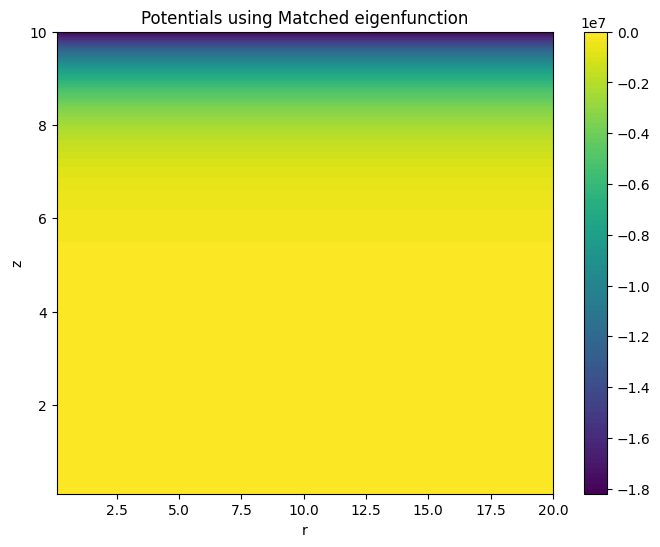

In [50]:

#phi_values[~region1 & ~region2 & ~regione ] = np.nan
plt.figure(figsize=(8, 6))
plt.contourf(r_grid, z_grid, phi_values,levels = 100)
plt.xlabel('r')
plt.ylabel('z')
plt.title('Potentials using Matched eigenfunction')
plt.colorbar()
plt.show()



In [51]:
from scipy.misc import derivative
from functools import partial
deriv_get_phi = lambda z: get_phi(z,r) # if fixing parameters
z=2
dphi_dz = derivative(deriv_get_phi, z, dx=1e-6)
dphi_dz

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


/var/folders/xb/j4pqwsmd1m56rwht_2pwqzfh0000gn/T/ipykernel_42472/913772660.py:5: DeprecationWarning: scipy.misc.derivative is deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. You may consider using findiff: https://github.com/maroba/findiff or numdifftools: https://github.com/pbrod/numdifftools
  dphi_dz = derivative(deriv_get_phi, z, dx=1e-6)


-6070.523717426113

In [43]:
phi = get_phi(r=10,z=10)
added_mass = np.real(1023*(h**3)*2*np.pi*integrate.romberg(lambda x: r*x,0,a1)*phi*dphi_dz) # %+ int(r,0,a2)) %dimension error

damping =   np.imag(1023*(h**3)*2*np.pi*integrate.romberg(lambda x: r*x,0,a1)*phi*dphi_dz)

added_mass


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19


-1.925067547934479e+58

In [44]:
damping

0.0